## Analysis of MonoBeams

New Boards for monobeam recording set up for Westring (RV) on 2024-05-22 (~12:00 UTC)

### Imports

In [1]:
import os
import numpy as np
import obspy as obs
import matplotlib.pyplot as plt

from andbro__read_sds import __read_sds
from scipy.signal import hilbert

from functions.compute_psd_array import __compute_psd_array


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
    bay_path = '/home/andbro/ontap-ffb-bay200/'
    lamont_path = '/home/andbro/lamont/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'
elif os.uname().nodename in ['lin-ffb-01', 'ambrym', 'hochfelln']:
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'
    bay_path = '/import/ontap-ffb-bay200/'
    lamont_path = '/lamont/'

In [3]:
def __get_inventory_from_client(config):

    from obspy.clients.fdsn import Client

    cli = Client(base_url=config['client'], timeout=100)

    try:
        inv = cli.get_stations(network=config['seed'].split(".")[0],
                               station=config['seed'].split(".")[1],
                               location=config['seed'].split(".")[2],
                               channel='*',
                               starttime=config['tbeg'],
                               endtime=config['tend'],
                               level="response")
    except:
        print(f"ERROR: failed to load inventory for {config['seed'].split('.')[1]}!")

    return inv

### Configurations

In [43]:
config = {}

config['ring'] = "Z"

# define data seed
config['seeds'] = ["BW.DROMY..F1V",
                   "BW.DROMY..F2V",
                   "BW.DROMY..FJZ",
                   # "BW.ROMY.10.BJZ"
                  ]

# checkup
config['tbeg'] = obs.UTCDateTime("2024-07-29 16:50")
config['tend'] = obs.UTCDateTime("2024-07-29 17:00")

# checkup after new setup (PD switch)
config['tbeg'] = obs.UTCDateTime("2024-08-01 13:30")
config['tend'] = obs.UTCDateTime("2024-08-01 13:40")

# checkup after new intensity control
config['tbeg'] = obs.UTCDateTime("2024-08-07 11:30")
config['tend'] = obs.UTCDateTime("2024-08-07 11:35")

# set freq zoom
config['flower'], config['fupper'] = 550, 555

# path to SDS data archive
config['path_to_sds'] = archive_path+"romy_archive/"

# path to signal data
config['path_to_data'] = archive_path+f"romy_autodata/{config['tbeg'].year}/R{config['ring']}/"

# path to store figures
config['path_to_figs'] = data_path+"mono_beams/figures/"

### Load Data

 -> loading BW.DROMY..F1V...
 -> loading BW.DROMY..F2V...
 -> loading BW.DROMY..FJZ...


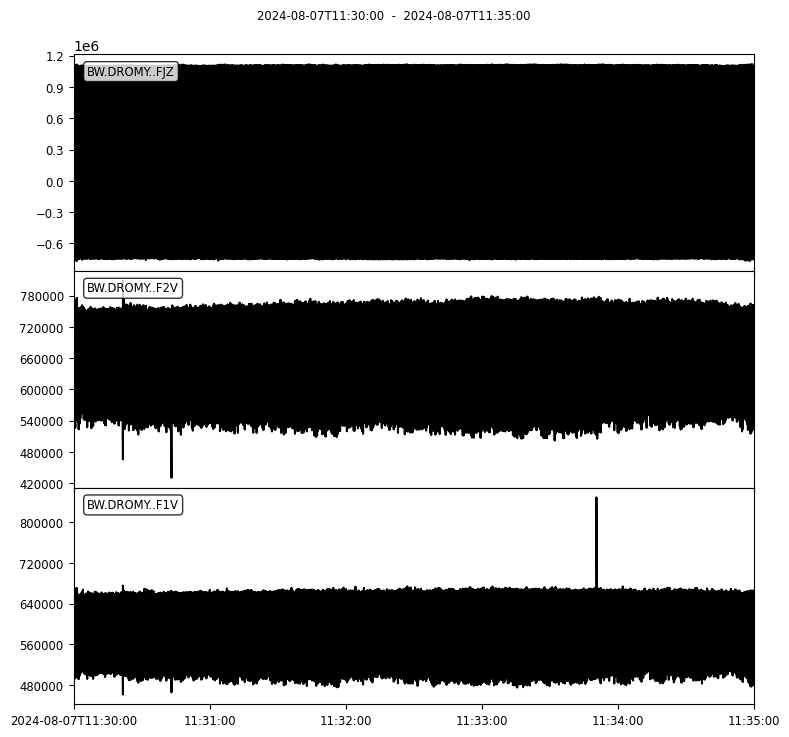

In [44]:
st0 = obs.Stream()

for seed in config['seeds']:

    print(f" -> loading {seed}...")

    try:
        st00 = __read_sds(config['path_to_sds'], seed, config['tbeg'], config['tend'], data_format='MSEED')
    except:
        print(f" -> failed for {seed}")

    if len(st00) != 0:
        st0 += st00

st0 = st0.sort()

st0.plot(equal_scale=False);

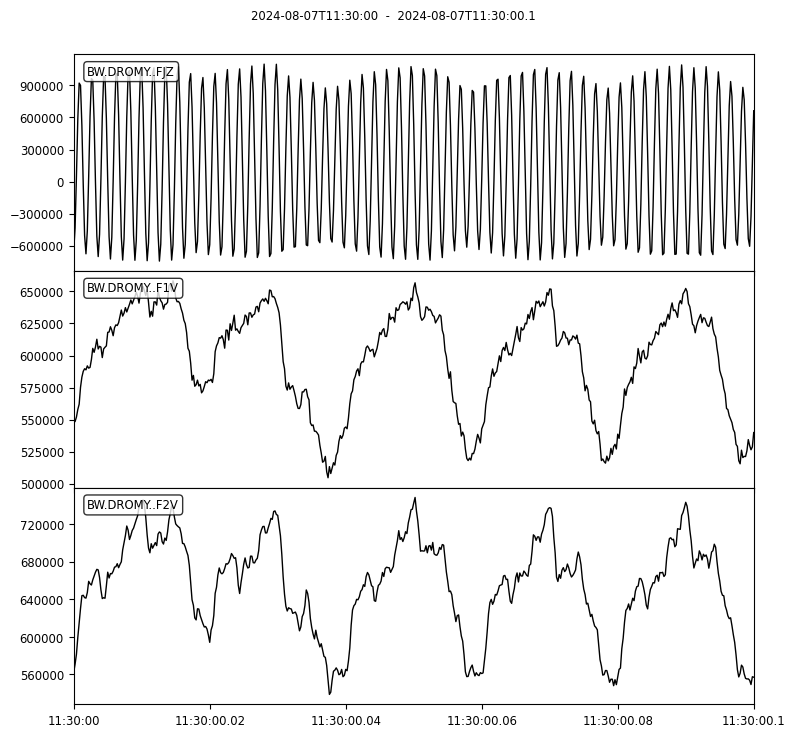

In [45]:
st0.copy().trim(config['tbeg'], config['tbeg']+0.1).plot(equal_scale=False);

## Modify Data

In [46]:
st = st0.copy()

st = st.split().merge(fill_value="interpolate")

st = st.sort(['channel'])

### convert from counts to volts: 0.59604645ug  from obsidian

In [47]:
for tr in st:
    if tr.stats.station == "DROMY":
        tr.data = tr.data*0.59604645e-6 # V / count  [0.59604645ug  from obsidian]

stx = st.select(station="DROMY")

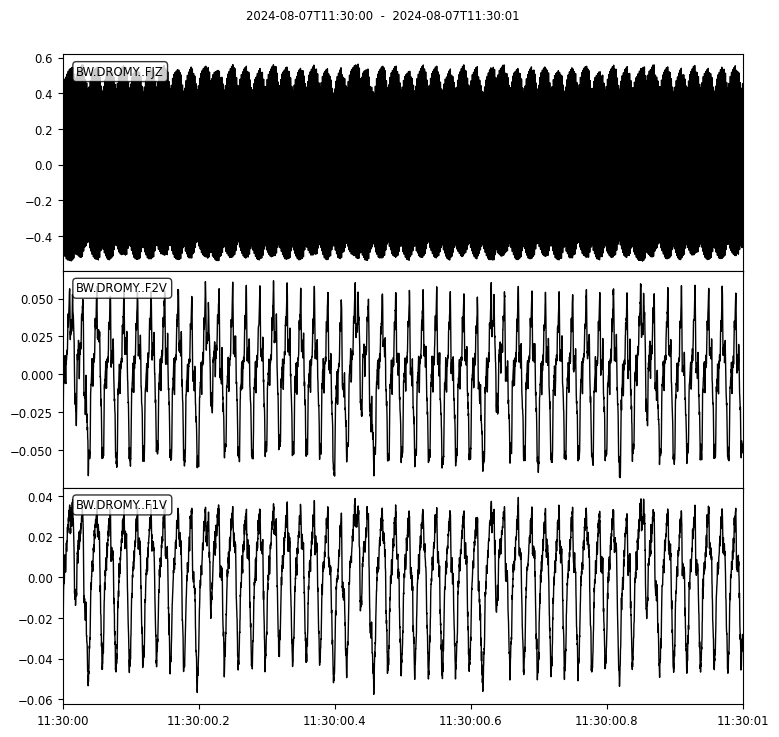

In [60]:
st.copy().sort().trim(config['tbeg'], config['tbeg']+1).plot(equal_scale=False);

In [64]:
st.detrend("linear")
st.filter("bandpass", freqmin=540, freqmax=560,  zerophase=True)

3 Trace(s) in Stream:
BW.DROMY..F1V | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples
BW.DROMY..F2V | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples
BW.DROMY..FJZ | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples

3 Trace(s) in Stream:
BW.DROMY..F1V | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples
BW.DROMY..F2V | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples
BW.DROMY..FJZ | 2024-08-07T11:30:00.000000Z - 2024-08-07T11:35:00.000000Z | 5000.0 Hz, 1500001 samples

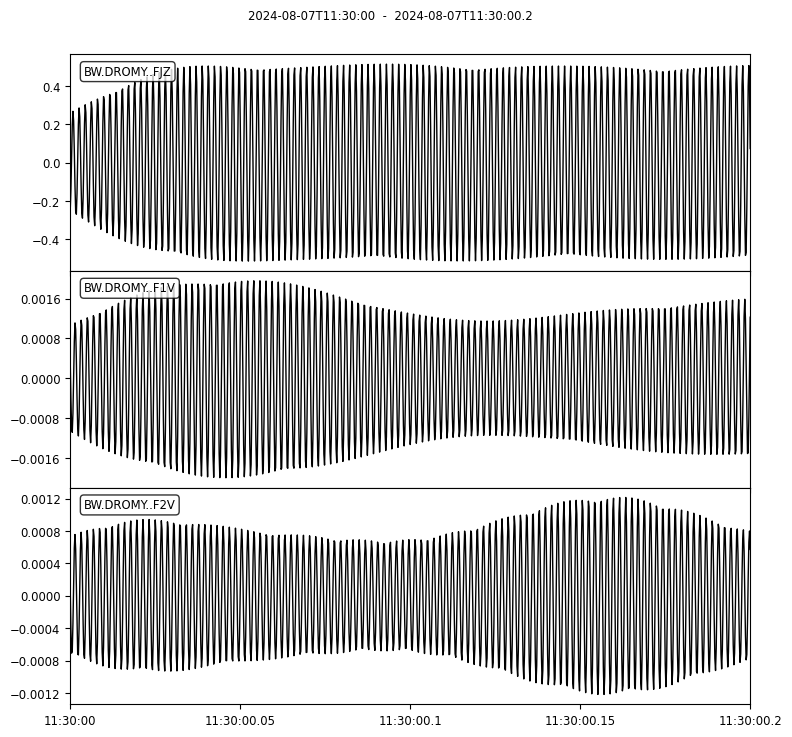

In [67]:
st.copy().sort().trim(config['tbeg'], config['tbeg']+0.2).plot(equal_scale=False);

## Plot

In [38]:
def __compute_psd_array(st0, twin_sec=60, spec="PSD"):

    from scipy.signal import welch
    from scipy.signal import get_window
    from scipy.fft import fft, fftfreq, fftshift
    from scipy import signal
    from numpy import angle, imag

    def __get_fft(signal_in, dt, window=None):

        ## determine length of the input time series
        n = int(len(signal_in))


        ## calculate spectrum (with or without window function applied to time series)
        if window:
            win = signal.get_window(window, n);
            spectrum = fft(signal_in * win)

        else:
            spectrum = fft(signal_in)

        ## calculate frequency array
        frequencies = fftfreq(n, d=dt)


        ## correct amplitudes of spectrum
        magnitude = abs(spectrum) * 2.0 / n


        phase = angle(spectrum, deg=False)
        # phase = imag(spectrum)

        ## return the positive frequencies
        return  magnitude[0:n//2], frequencies[0:n//2], phase[0:n//2]

    _st = st0.copy()

    _st.sort(keys=['channel'], reverse=True)

    nblock = int(_st[0].stats.sampling_rate * twin_sec)
    overlap = int(0.5*nblock)
    win = get_window('hann', nblock, True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(_st):
        if spec.upper() == "PSD":
            ff, Pxx = welch(tr.data,
                            fs=tr.stats.sampling_rate,
                            window=win,
                            noverlap=overlap,
                            nfft=nblock,
                            scaling="density",
                            return_onesided=True)

        elif spec.upper() == "FFT":
            Pxx, ff, ph = __get_fft(tr.data, tr.stats.delta)

        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

    out = {}
    out['Pxxs'] = Pxxs
    out['ffs'] = ffs
    out['chs'] = chs

    return out

In [39]:
out = __compute_psd_array(stx, twin_sec=30, spec="PSD")

In [40]:
Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']

### Plot PSD

In [49]:
def __makeplot_stream_PSD(st, twin_sec, f_lower_zoom=540, f_upper_zoom=560):

    from scipy import fftpack
    from numpy import abs
    from scipy import signal
    import matplotlib.pyplot as plt

    def __fft(signal_in, dt, window=None):

        from scipy.fft import fft, fftfreq, fftshift
        from scipy import signal
        from numpy import angle

        ## determine length of the input time series
        n = int(len(signal_in))


        ## calculate spectrum (with or without window function applied to time series)
        if window:
            win = signal.get_window(window, n);
            spectrum = fft(signal_in * win)

        else:
            spectrum = fft(signal_in)

        ## calculate frequency array
        frequencies = fftfreq(n, d=dt)


        ## correct amplitudes of spectrum
        magnitude = 2.0 / n * abs(spectrum)


        phase = angle(spectrum, deg=False)
        # phase = imag(spectrum)

        ## return the positive frequencies
        return frequencies[0:n//2], magnitude[0:n//2], phase[0:n//2]


    nblock = int(st[0].stats.sampling_rate * twin_sec)

    overlap = int(0.5*nblock)

    print(f" -> nseg = {nblock} | overlap = {overlap}")

    win = signal.get_window("hann", nblock)


    fig, axes = plt.subplots(len(st),2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.1)

    font = 12

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)

    Pxxs, ffs, chs = [], [], []

    for i, tr in enumerate(st):

        ff, Pxx = signal.welch(tr.data,
                               fs=tr.stats.sampling_rate,
                               window=win,
                               noverlap=overlap,
                               nfft=nblock,
                               scaling="density",
                               return_onesided=True,
                              )

        # ff, Pxx, ph = __fft(tr.data,
        #                     tr.stats.delta,
        #                     window="hann",
        #                    )


        ffs.append(ff)
        chs.append(tr.stats.channel)
        Pxxs.append(Pxx)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()[:400],
                    tr.data[:400],
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].semilogy(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )

        axes[i,1].set_ylim(min(Pxx[10:]), max(Pxx[10:]))

        axes[i,0].set_ylabel(r'Voltage (V)', fontsize=font)

        axes[i,1].set_ylabel(r'PSD (V$^2$/Hz)', fontsize=font)

        axes[2,0].set_xlabel(r'Time (s)', fontsize=font)

        axes[2,1].set_xlabel(r'Frequency (Hz)', fontsize=font)

        axes[i,0].legend(loc='upper left', framealpha=.8)

#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(f_lower_zoom, f_upper_zoom)
        axes[i,1].set_ylim(1e-10, 1e0)


    plt.show();
    return fig, (Pxxs, ffs, chs)

 -> nseg = 150000 | overlap = 75000


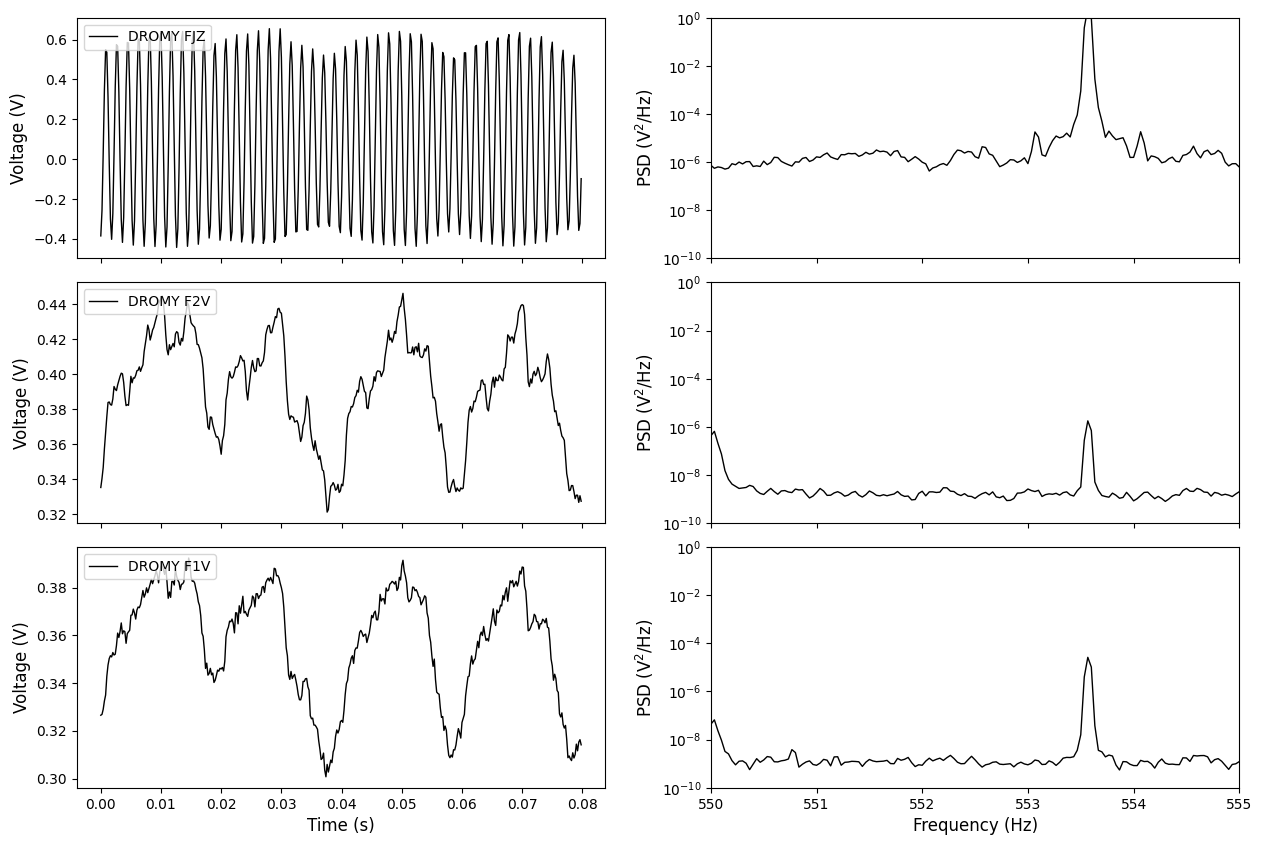

In [50]:
fig, _ = __makeplot_stream_PSD(stx, twin_sec=30, f_lower_zoom=config['flower'], f_upper_zoom=config['fupper']);

# fig.savefig(config['path_to_figs']+f"Monobeams_R{config['ring']}_{stx[0].stats.starttime.date}_trace&PSD.png", format="png", dpi=150, bbox_inches='tight')


In [51]:
# m1 = st0.select(channel="F1V")[0].data
# m2 = st0.select(channel="F2V")[0].data
# res = m1 - m2

# plt.plot(res[0:300])

## Spectrogram

In [52]:
# params = [1048, 128, 32]

# for tr in stx:
#     __makeplot_trace_spectrogram(tr, unit='hour', normalize=True, spec_param=params);

# plt.show();

## PSD Overview

In [53]:
def __makelot_psd():

    plt.figure(figsize=(15, 10))

    for f, pxx, cha in zip(ffs, Pxxs, chs):

        if cha == "FJZ":
            plt.plot(f, pxx, label=cha, zorder=1)
        else:
            plt.plot(f, pxx, label=cha, zorder=2)

        plt.xscale("log")
        plt.yscale("log")

    #     plt.xlim(500, 560)

        plt.ylim(1e-10, 1e-3)

        plt.legend(loc=1)

        plt.ylabel(r"PSD (V/$\sqrt{Hz}$)", fontsize=14)
        plt.xlabel("Frequency (Hz)", fontsize=14)

        plt.grid(which="both", ls=":", zorder=-1, alpha=0.7)

    plt.show();
    return fig

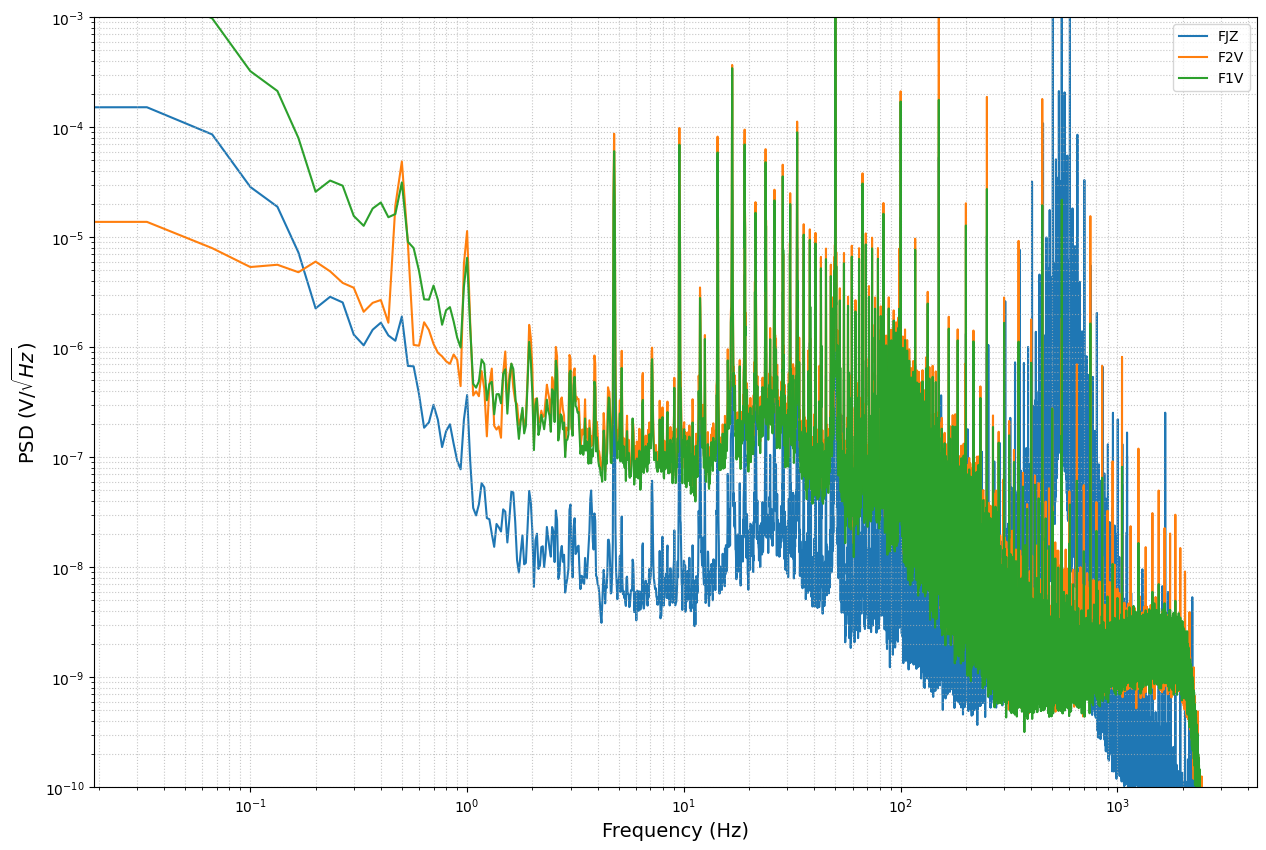

In [54]:

fig = __makelot_psd()

fig.savefig(config['path_to_figs']+f"Monobeams_R{config['ring']}_PSDoverview_{stx[0].stats.starttime.date}.png", format="png", dpi=150, bbox_inches='tight')


In [55]:
def __makeplot_psd_overview_with_zoomin(Pxxs, ffs, chs, fmin, fmax):

    from matplotlib.gridspec import GridSpec
    from functions.to_dB import __to_dB
    from numpy import log10

    font = 14

    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(1, 2, width_ratios=[2, 1])


    max_db = []
    for jj in range(len(Pxxs)):
        max_db.append(max(__to_dB(Pxxs[jj])))
    max_max_db = round(max(max_db), 0)


    ax1 = fig.add_subplot(gs[0])
    ax1.semilogx(ffs[0], __to_dB(Pxxs[0], power=True), alpha=0.5, color="tab:blue", label=chs[0])
    ax1.semilogx(ffs[1], __to_dB(Pxxs[1], power=True), alpha=0.5, color="tab:orange", label=chs[1])
    ax1.semilogx(ffs[2], __to_dB(Pxxs[2], power=True), alpha=0.5, color="tab:green", label=chs[2], zorder=2)

    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)

    ax1.set_ylim(-110, max_max_db)



    ax2 = fig.add_subplot(gs[1])
    ax2.plot(ffs[0], __to_dB(Pxxs[0], power=True), alpha=0.5, color="tab:blue")
    ax2.plot(ffs[1], __to_dB(Pxxs[1], power=True), alpha=0.5, color="tab:orange")
    ax2.plot(ffs[2], __to_dB(Pxxs[2], power=True), alpha=0.5, color="tab:green", zorder=2)

    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)
    ax2.set_yticklabels([])

    ax2.set_ylim(-110, max_max_db)
    ax2.set_xlim(fmin, fmax)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)

    time_str = f"{str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    ax1.set_title(f"{stx[0].stats.starttime.date} {time_str}")

    plt.show();
    return fig

In [56]:
# fig = __makeplot_psd_overview_with_zoomin(Pxxs, ffs, chs, config['flower'], config['fupper'])

# fig.savefig(config['path_to_figs']+f"Monobeams_Westring_{stx[0].stats.starttime.date}.png", format="png", dpi=150, bbox_inches='tight')


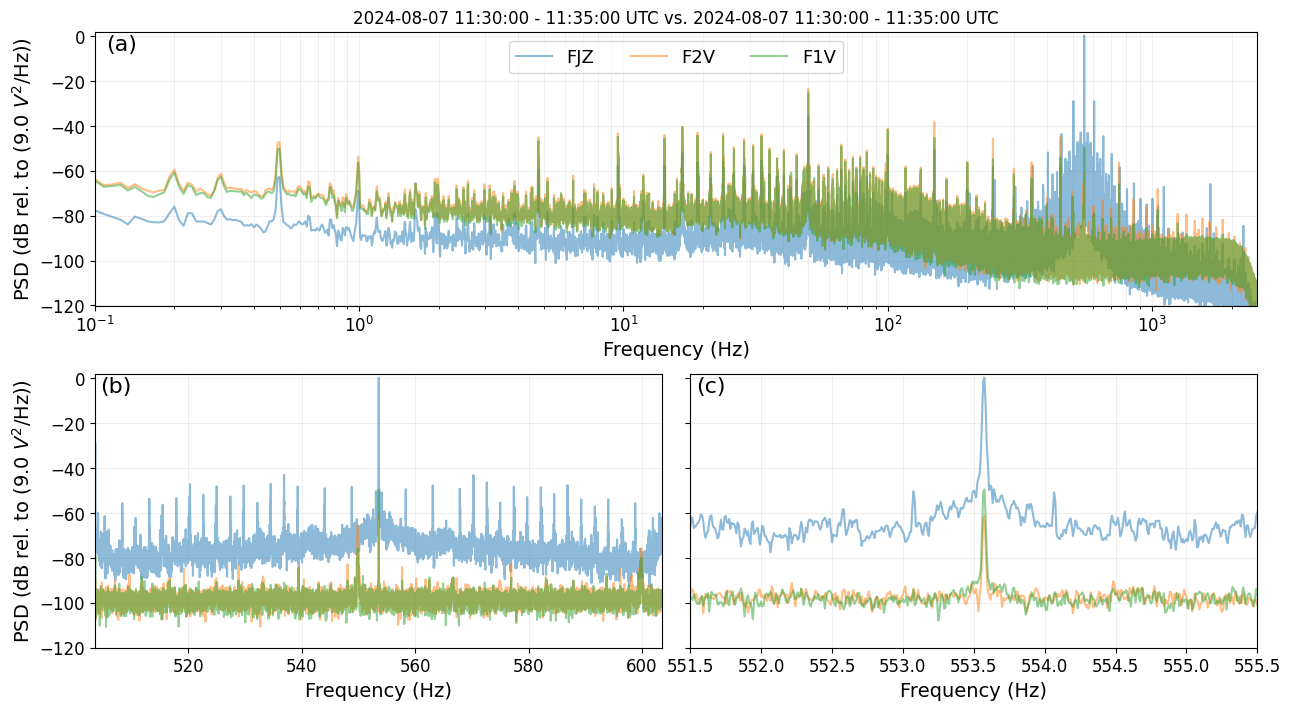

In [57]:
def __makeplot_psd_overview(stx, twin_sec=30, plot_dB=True):

    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from functions.to_dB import __to_dB
    from functions.compute_psd_array import __compute_psd_array
    # from functions.get_fft import __get_fft

    font = 14

    f_lower_zoom1 = 553.5 - 50
    f_upper_zoom1 = 553.5 + 50

    f_lower_zoom2 = 553.5 - 2
    f_upper_zoom2 = 553.5 + 2


    stx = stx.detrend("demean")

    out = __compute_psd_array(stx, twin_sec=twin_sec)
    Pxxs, ffs, chs = out['Pxxs'], out['ffs'], out['chs']


    fig = plt.figure(figsize=(15, 8))

    plt.subplots_adjust(wspace=0.05)

    gs = GridSpec(2, 2, hspace=0.25)

    ax1 = fig.add_subplot(gs[0, :])
    ax2 = fig.add_subplot(gs[1, :1])
    ax3 = fig.add_subplot(gs[1, 1:])


    if plot_dB:
        max_db = []
        for jj in range(len(Pxxs)):
            max_db.append(max(__to_dB(Pxxs[jj])))
    max_max_db = round(max(max_db), 0)


    for jj in range(len(Pxxs)):
        if plot_dB:
            ax1.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
            ax2.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])
            ax3.plot(ffs[jj], __to_dB(Pxxs[jj])-max_max_db, alpha=0.5, label=chs[jj])

        else:
            ax1.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])
            ax2.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])
            ax3.loglog(ffs[1], Pxxs[0], alpha=0.5, label=chs[1])


    ax1.grid(alpha=0.2, which="both")
    ax1.set_xlabel("Frequency (Hz)", fontsize=font)
    ax1.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
    ax1.legend(loc="upper center", fontsize=font-1, ncol=3)
    ax1.tick_params(labelsize=font-2)
    ax1.set_xscale("log")
    ax1.set_xlim(1e-1, 2500)

    ax2.set_ylabel(f"PSD (dB rel. to ({max_max_db} $V^2$/Hz))", fontsize=font)
    ax2.set_xlabel("Frequency (Hz)", fontsize=font)
    ax2.grid(alpha=0.2, which="both")
    ax2.tick_params(labelsize=font-2)

    ax3.set_xlabel("Frequency (Hz)", fontsize=font)
    ax3.grid(alpha=0.2, which="both")
    ax3.tick_params(labelsize=font-2)
    ax3.set_yticklabels([])


    ax2.set_xlim(f_lower_zoom1, f_upper_zoom1)
    ax3.set_xlim(f_lower_zoom2, f_upper_zoom2)

    ax1.set_ylim(-120, 2)
    ax2.set_ylim(-120, 2)
    ax3.set_ylim(-120, 2)

    ax1.text(.01, .99, '(a)', ha='left', va='top', transform=ax1.transAxes, fontsize=font+2)
    ax2.text(.01, .99, '(b)', ha='left', va='top', transform=ax2.transAxes, fontsize=font+2)
    ax3.text(.01, .99, '(c)', ha='left', va='top', transform=ax3.transAxes, fontsize=font+2)

    time_str1 = f"{stx[0].stats.starttime.date} {str(stx[0].stats.starttime.time).split('.')[0]} - {str(stx[0].stats.endtime.time).split('.')[0]} UTC"
    time_str2 = f"{stx[1].stats.starttime.date} {str(stx[1].stats.starttime.time).split('.')[0]} - {str(stx[1].stats.endtime.time).split('.')[0]} UTC"

    ax1.set_title(f"{time_str1} vs. {time_str2}")

    plt.show();
    return fig

fig = __makeplot_psd_overview(stx, twin_sec=120, plot_dB=True);

# fig.savefig(config['path_to_figs']+f"Monobeams_PSD_R{config['ring']}_{st[0].stats.channel}_{st[1].stats.channel}_overview.png", format="png", dpi=150, bbox_inches='tight')


### Plot Saganc Frequency

In [58]:
config['path_to_data']+f"{config['tbeg'].year}/R{config['ring']}/FJ{config['ring']}_{config['tbeg'].year}{config['tbeg'].month}{config['tbeg'].day}.pkl"

'/import/freenas-ffb-01-data/romy_autodata/2024/RZ/2024/RZ/FJZ_202487.pkl'

In [23]:
from pandas import read_pickle

date_str = f"{config['tbeg'].year}{str(config['tbeg'].month).rjust(2,'0')}{str(config['tbeg'].day).rjust(2,'0')}"

df = read_pickle(config['path_to_data']+f"/FJ{config['ring']}_{date_str}.pkl")

df.sort_values(by="times_mjd", inplace=True)

df.reset_index(drop=True, inplace=True)

df

FileNotFoundError: [Errno 2] No such file or directory: '/import/freenas-ffb-01-data/romy_autodata/2024/RZ//FJZ_20240801.pkl'

In [ ]:
def __makeplot_overview2(df):


    N = 5
    font = 12
    ms = 5

    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    # plt.subplots_adjust(wspace=0.2)


    ## ______________________________

    ax[0].scatter(df.times_mjd, df.fj, c="tab:blue", label="FJ", s=ms, alpha=0.4, zorder=2)
    ax[0].scatter(df.times_mjd, df.f1, c="tab:orange", label="CCW", s=ms, alpha=0.4, zorder=2)
    ax[0].scatter(df.times_mjd, df.f2, c="tab:red", label="CW", s=ms, alpha=0.4, zorder=2)

    ax[0].ticklabel_format(useOffset=False, style='plain')
    ax[0].set_ylabel("Freq. (Hz)", fontsize=font)
    ax[0].legend(loc=1, fontsize=font-2, ncol=3, bbox_to_anchor=(1, 1.3))


    ## ______________________________

    ax[1].scatter(df.times_mjd, df.fj, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[1].scatter(df.times_mjd, df.f1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[1].scatter(df.times_mjd, df.f2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[1].set_ylim(df.fj.mean()-2*df.fj.std(), df.fj.mean()+2*df.fj.std())
    ax[1].ticklabel_format(useOffset=False, style='plain')
    ax[1].set_ylabel("Freq. (Hz)", fontsize=font)

    ## ______________________________

    ax[2].scatter(df.times_mjd, df.ac_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[2].scatter(df.times_mjd, df.ac_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[2].scatter(df.times_mjd, df.ac_2, c="tab:red", s=ms, alpha=0.4, zorder=2)


    ax[2].set_ylim(0, 0.5)
    ax[2].set_ylabel("AC (V)", fontsize=font)

    ## ______________________________

    ax[3].scatter(df.times_mjd, df.dc_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[3].scatter(df.times_mjd, df.dc_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[3].scatter(df.times_mjd, df.dc_2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[3].set_ylabel("DC (V)", fontsize=font)

    ## ______________________________

    ax[4].scatter(df.times_mjd, df.contrast_z, c="tab:blue", s=ms, alpha=0.4, zorder=2)
    ax[4].scatter(df.times_mjd, df.contrast_1, c="tab:orange", s=ms, alpha=0.4, zorder=2)
    ax[4].scatter(df.times_mjd, df.contrast_2, c="tab:red", s=ms, alpha=0.4, zorder=2)

    ax[4].set_ylim(0, 0.5)
    ax[4].set_ylabel("Contrast (V)", fontsize=font)



    for n in range(N):
        ax[n].grid(alpha=0.8, ls=":", zorder=0)


    ax[N-1].set_xlabel("Time (mjd)")
    ax[0].set_title("ROMY-Z Sagnac Signal ", fontsize=font+1, pad=10)


    return fig

In [ ]:
__makeplot_overview2(df);